# BUILDING A SIMPLE RECOMMENDER SYSTEM 
If you go for a simple collaborative filtering recommender system, it can be as simple as keeping a user-user similarity matrix and recommending items which the user hasn't seen but has been liked by other users very similar to your current user.

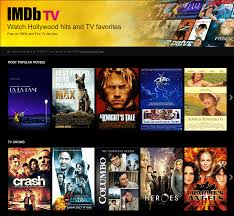

* All  IMDB users can cast vote for any movie.
* They don't use mean or average for the average rating. Instead, they use the weighted average rating.
> WeightedRating(WR)=(vv+m⋅R)+(mv+m⋅C)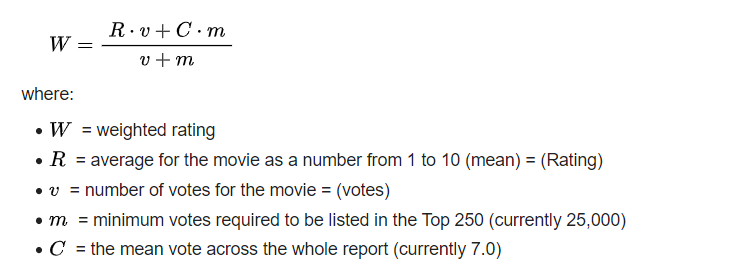


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [ ]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [ ]:
#Reading the data
dat = pd.read_csv('/kaggle/input/tmdb-top-10000-popular-movies-dataset/TMDb_updated.CSV')

In [ ]:
#Glimpse of the dataset
dat.head(10)

In [ ]:
dat.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
dat.head()

# EXPLORATORY DATA ANALYSIS

In [ ]:
#Checking the columns and info of the data
col = dat.columns
print("The columns are",col)
inf = dat.info()
desc = dat.describe()
inf, desc

In [ ]:
#CHECKING FOR NULL VALUES
dat.isnull().sum()

* There are few missing values in the overview column, since we can't be searching and replacing each and everything, we will replace it with an empty string.


In [ ]:
#Replacing with an empty string
dat['overview'] = dat.overview.replace(np.NaN,'')

In [ ]:
dat.isnull().sum()

* Perfect, no Null/Missing value

In [ ]:
from matplotlib import rcParams

# figure size in inches
#plt.figure(figsize=(8,4)) # this creates a figure 8 inch wide, 4 inch high

rcParams['figure.figsize'] = 11.7,11.27

In [ ]:
#Analysing which language has the most number of movies, according to the dataset
sns.countplot(y='original_language',data=dat, order = dat['original_language'].value_counts().index)

*Looks like the most number of movies is in English, followed by French  

In [ ]:
#Distplot on average voting
sns.distplot(dat['vote_average'],kde=False)

* So, the average voting is somewhere between 4 and 8.

In [ ]:
#Plotting a graph for the top 10 movies which has the most number of votes
sns.barplot(y=dat[dat.vote_count > 100].sort_values(by='vote_count',ascending=False)['title'].head(10),x='vote_count',data=dat)

In [ ]:
#Moving on to the Machine learning part.
#Calculating the weighted average.
# Calculate mean of vote average column
C = dat['vote_average'].mean()
print(C)

In [ ]:
# Calculate the minimum number of votes required to be in the chart, m
#We take 80th percentile
m = dat['vote_count'].quantile(0.80)
print(m)

* We select movies with atleast 1219 votes.

In [ ]:
#Making a new DF so we dont make any changes to the existing one
new_movies = dat.copy().loc[dat['vote_count'] >= m]
new_movies.shape

In [ ]:
new_movies.head()

**** calculate the weighted rating for each qualified movie.****

In [ ]:
def rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
#applying this to our new dataset:
new_movies['w_rating'] = new_movies.apply(rating, axis=1)

In [ ]:
#Sorting the new dataframe according the highest rating
new_movies = new_movies.sort_values('w_rating',ascending=False)
new_movies.head(10)

In [ ]:
#Making a content based recommender through a tutorial: by making use of the overview .


In [ ]:
overv = dat['overview'].head(10)
overv

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')
#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(dat['overview'])

In [ ]:
tfidf_matrix.shape


In [ ]:
tfidf.get_feature_names()[5000:5010]

In [ ]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim.shape


In [ ]:
cosine_sim[1]

In [ ]:
#define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies
indices = pd.Series(dat.index, index=dat['title']).drop_duplicates()
indices[:10]

In [ ]:
#Function for getting similar movies to the given input movie.
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return dat['title'].iloc[movie_indices]

In [ ]:
rec_movies = pd.DataFrame(get_recommendations('Bad Boys'))
rec_movies

* Movies similar to Bad Boys

In [ ]:
rec_movies = pd.DataFrame(get_recommendations('Fight Club'))
rec_movies

* List of movies similar to Fight Club